Ici on fait de l'ACP sur les données

In [109]:
library("dplyr")
library("FactoMineR")

In [126]:
# CHARGER les données
data_20_stations <- read.csv("../data/mesures/donnees_extracted_metro_20.csv")
summary(data_20_stations)

 ID.OMM.station     Date           Pression.au.niveau.mer
 Min.   :7020   Length:465844      Min.   : 95780        
 1st Qu.:7149   Class :character   1st Qu.:101260        
 Median :7510   Mode  :character   Median :101730        
 Mean   :7417                      Mean   :101710        
 3rd Qu.:7650                      3rd Qu.:102230        
 Max.   :7790                      Max.   :104890        
                                   NA's   :50165         
 Variation.de.pression.en.3.heures Type.de.tendance.barométrique
 Min.   :-1780.000                 Min.   :0.000                
 1st Qu.:  -70.000                 1st Qu.:2.000                
 Median :    0.000                 Median :4.000                
 Mean   :    2.588                 Mean   :4.324                
 3rd Qu.:   70.000                 3rd Qu.:7.000                
 Max.   : 1330.000                 Max.   :8.000                
 NA's   :19075                     NA's   :19075                
 Direction.du.ve

In [111]:
head(data_20_stations)
na_proportions <- colMeans(is.na(data_20_stations))
cat(na_proportions)
for (col in names(na_proportions)) {
  cat(col, ":", round(na_proportions[col] * 100, 2), "% de NA\n")
}

,ID.OMM.station,Date,Pression.au.niveau.mer,Variation.de.pression.en.3.heures,Type.de.tendance.barométrique,Direction.du.vent.moyen.10.mn,Vitesse.du.vent.moyen.10.mn,Température,Point.de.rosée,Humidité,⋯,Altitude,communes..name.,communes..code.,EPCI..name.,EPCI..code.,department..name.,department..code.,region..name.,region..code.,mois_de_l_annee
,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<int>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<int>
1,7020,2017-01-12T13:00:00+01:00,100580,-710,8,210,11.9,282.05,280.15,88,⋯,6,La Hague,50041,CA du Cotentin,200067205,Manche,50,Normandie,28,1
2,7280,2017-12-23T13:00:00+01:00,103830,-10,0,10,2.7,280.75,278.35,85,⋯,219,Ouges,21473,Dijon Métropole,242100410,Côte-d'Or,21,Bourgogne-Franche-Comté,27,12
3,7790,2018-01-21T01:00:00+01:00,100610,-320,8,270,1.8,280.05,277.35,83,⋯,10,Lucciana,2b148,CC de Marana-Golo,200036499,Haute-Corse,2b,Corse,94,1
4,7510,2018-01-22T16:00:00+01:00,102480,40,3,300,7.1,286.85,284.75,87,⋯,47,Mérignac,33281,Bordeaux Métropole,243300316,Gironde,33,Nouvelle-Aquitaine,75,1
5,7020,2017-10-14T17:00:00+02:00,102450,-80,6,80,2.7,291.05,286.95,77,⋯,6,La Hague,50041,CA du Cotentin,200067205,Manche,50,Normandie,28,10
6,7149,2017-11-09T19:00:00+01:00,102630,50,3,210,1.6,281.75,277.75,76,⋯,89,Athis-Mons,91027,Métropole du Grand Paris,200054781,Essonne,91,Île-de-France,11,11


0 0 0.1076863 0.04094718 0.04094718 0.004913662 0.004634599 0.03756837 0.04343514 0.04328058 0.1629795 0.1632907 0.6457269 0.8281163 0.4872103 0.2605915 0.4600703 0.6910124 0.7738299 0.809346 0.04065309 0.9887258 0.9548819 0.05461485 0.7675574 0.9721108 0.7675552 0.9721108 0.4200204 1 1 0.03672259 0.02585844 0.02037163 0.3984531 0.3647251 0.9344716 0.9397008 0.0484776 0.04645332 0.06063189 0.07025743 0.08402384 1 1 1 1 0.4482123 0.7259769 0.4681224 0.7397219 0.8763814 0.7432381 0.8970342 0.9585204 0.8972811 0.9950928 0.9795747 0.9950928 0 0 0 0 0 0.03756837 0.7675574 0.9721108 0.7675552 0.9721108 0.4200204 0 0 0 0 0 0 0 0 0 0 0 0ID.OMM.station : 0 % de NA
Date : 0 % de NA
Pression.au.niveau.mer : 10.77 % de NA
Variation.de.pression.en.3.heures : 4.09 % de NA
Type.de.tendance.barométrique : 4.09 % de NA
Direction.du.vent.moyen.10.mn : 0.49 % de NA
Vitesse.du.vent.moyen.10.mn : 0.46 % de NA
Température : 3.76 % de NA
Point.de.rosée : 4.34 % de NA
Humidité : 4.33 % de NA
Visibilité.horizo

In [112]:
cat(colnames(data_20_stations))

ID.OMM.station Date Pression.au.niveau.mer Variation.de.pression.en.3.heures Type.de.tendance.barométrique Direction.du.vent.moyen.10.mn Vitesse.du.vent.moyen.10.mn Température Point.de.rosée Humidité Visibilité.horizontale Temps.présent Temps.passé.1 Temps.passé.2 Nebulosité.totale Nébulosité..des.nuages.de.l..étage.inférieur Hauteur.de.la.base.des.nuages.de.l.étage.inférieur Type.des.nuages.de.l.étage.inférieur Type.des.nuages.de.l.étage.moyen Type.des.nuages.de.l.étage.supérieur Pression.station Niveau.barométrique Géopotentiel Variation.de.pression.en.24.heures Température.minimale.sur.12.heures Température.minimale.sur.24.heures Température.maximale.sur.12.heures Température.maximale.sur.24.heures Température.minimale.du.sol.sur.12.heures Méthode.de.mesure.Température.du.thermomètre.mouillé Température.du.thermomètre.mouillé Rafale.sur.les.10.dernières.minutes Rafales.sur.une.période Periode.de.mesure.de.la.rafale Etat.du.sol Hauteur.totale.de.la.couche.de.neige..glace..autre.au.s

## Nettoyage du Df pour l'ACP

In [113]:
clean_for_acp <- function(df, 
                          id_cols = c(
                            "ID.OMM.station", 
                            "communes..code.", 
                            "EPCI..code.", 
                            "department..code.", 
                            "region..code."),
                          cat_cols = c(
                            "Type.de.tendance.barométrique", 
                            "Temps.présent", 
                            "Temps.passé.1", 
                            "Temps.passé.2", 
                            "Type.des.nuages.de.l.étage.inférieur", 
                            "Type.des.nuages.de.l.étage.moyen", 
                            "Type.des.nuages.de.l.étage.supérieur", 
                            "Type.nuage.1", 
                            "Type.nuage.2", 
                            "Type.nuage.3", 
                            "Type.nuage.4", 
                            "mois_de_l_annee", 
                            "Nebulosité.totale", 
                            "Nébulosité..des.nuages.de.l..étage.inférieur", 
                            "Nébulosité.couche.nuageuse.1", 
                            "Nébulosité.couche.nuageuse.2", 
                            "Nébulosité.couche.nuageuse.3", 
                            "Nébulosité.couche.nuageuse.4",
                            "Etat.du.sol",
                            "Periode.de.mesure.de.la.neige.fraiche",
                            "Periode.de.mesure.de.la.rafale"
                            ),
                          other_cols = c()) {
  cat("Columns before cleaning:", colnames(df), "\n")
  cat("Data Frame Size:", dim(df), "\n")
  
  # Select only numeric columns
  df_numeric <- df %>% select_if(is.numeric)
  cat("Removed NaN columns:", setdiff(colnames(df), colnames(df_numeric)), "\n")
  df <- df %>% select_if(is.numeric)
  cat("Columns after numeric selection:", colnames(df), "\n")
  cat("Data Frame Size:", dim(df), "\n")
  
  # Remove ID columns
  df_noId <- df[, !names(df) %in% id_cols]
  cat("Removed id colums:", setdiff(colnames(df), colnames(df_numeric)), "\n")
  df <- df_noId
  cat("Columns after removing ID columns:", colnames(df), "\n")
  cat("Data Frame Size:", dim(df), "\n")
  
  # Remove categorical columns
  df_quantitative <- df[, !names(df) %in% cat_cols]
  cat("Removed qualitative columns:", setdiff(colnames(df), colnames(df_quantitative)), "\n")
  df <- df_quantitative
  cat("Columns after removing categorical columns:", colnames(df), "\n")
  cat("Data Frame Size:", dim(df), "\n")

  # Remove other colums
  if (length(other_cols) > 0){
    df_nOther <- df[, !names(df) %in% other_cols]
    cat("Removed other columns:", setdiff(colnames(df), colnames(df_nOther)), "\n")
    df <- df_nOther
    cat("Columns after removing other colums:", colnames(df), "\n")
    cat("Data Frame Size:", dim(df), "\n") 
  }
  else {
     cat("No other columns to remove \n")
  }
  
  # Remove rows with NA
  cat("Cleaning NaN rows\n")
  df <- na.omit(df)
  cat("Data Frame Size after NA removal:", dim(df), "\n")

  # Remove constant columns
  const_columns <- sapply(df, function(x) length(unique(x)) == 1)
  df_noConst <- df[, !const_columns]
  cat("Removed constant columns:", setdiff(colnames(df), colnames(df_noConst)), "\n")
  df <- df_noConst
  cat("Columns after removing constant columns:", colnames(df), "\n")
  cat("Data Frame Size:", dim(df), "\n")

  cat("Remaining columns:", colnames(df), "\n")
  
  return(df)
}

# Usage:
data_for_acp <- clean_for_acp(data_20_stations, other_cols = c(
                                                              "Rafales.sur.une.période", 
                                                              "Température.minimale.sur.12.heures",
                                                              "Température.maximale.sur.12.heures",
                                                              "Température.minimale.sur.24.heures",
                                                              "Température.maximale.sur.24.heures",
                                                              "Température.minimale.sur.12.heures...C.",
                                                              "Température.maximale.sur.12.heures...C.",
                                                              "Température.minimale.sur.24.heures...C.",
                                                              "Température.maximale.sur.24.heures...C.",
                                                              "Hauteur.de.base.1",
                                                              "Hauteur.de.base.2",
                                                              "Hauteur.de.base.3",
                                                              "Hauteur.de.base.4",
                                                              "Niveau.barométrique",
                                                              "Géopotentiel",
                                                              "Précipitations.dans.la.dernière.heure",
                                                              "Précipitations.dans.les.3.dernières.heures",
                                                              "Précipitations.dans.les.6.dernières.heures",
                                                              "Précipitations.dans.les.12.dernières.heures",
                                                              "Précipitations.dans.les.24.dernières.heures"
                                                              ))

head(data_for_acp, 24)

# le SEUL ID bien pour temp min 24: 7791

Columns before cleaning: ID.OMM.station Date Pression.au.niveau.mer Variation.de.pression.en.3.heures Type.de.tendance.barométrique Direction.du.vent.moyen.10.mn Vitesse.du.vent.moyen.10.mn Température Point.de.rosée Humidité Visibilité.horizontale Temps.présent Temps.passé.1 Temps.passé.2 Nebulosité.totale Nébulosité..des.nuages.de.l..étage.inférieur Hauteur.de.la.base.des.nuages.de.l.étage.inférieur Type.des.nuages.de.l.étage.inférieur Type.des.nuages.de.l.étage.moyen Type.des.nuages.de.l.étage.supérieur Pression.station Niveau.barométrique Géopotentiel Variation.de.pression.en.24.heures Température.minimale.sur.12.heures Température.minimale.sur.24.heures Température.maximale.sur.12.heures Température.maximale.sur.24.heures Température.minimale.du.sol.sur.12.heures Méthode.de.mesure.Température.du.thermomètre.mouillé Température.du.thermomètre.mouillé Rafale.sur.les.10.dernières.minutes Rafales.sur.une.période Periode.de.mesure.de.la.rafale Etat.du.sol Hauteur.totale.de.la.couche.de

,Pression.au.niveau.mer,Variation.de.pression.en.3.heures,Direction.du.vent.moyen.10.mn,Vitesse.du.vent.moyen.10.mn,Température,Point.de.rosée,Humidité,Visibilité.horizontale,Hauteur.de.la.base.des.nuages.de.l.étage.inférieur,Pression.station,Variation.de.pression.en.24.heures,Température.minimale.du.sol.sur.12.heures,Rafale.sur.les.10.dernières.minutes,Hauteur.totale.de.la.couche.de.neige..glace..autre.au.sol,Hauteur.de.la.neige.fraîche,Température...C.,Température.minimale.du.sol.sur.12.heures..en..C.,Latitude,Longitude,Altitude
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
7,100400,140,20,13.3,283.85,276.35,60,20000,800,100260,480,279.15,19.8,0,0,10.7,6.0,42.54067,9.485167,10
68,102070,-160,140,4.3,293.75,285.95,61,30000,1250,101930,-270,281.75,6.4,0,0,20.6,8.6,42.54067,9.485167,10
140,100900,160,340,5.7,282.25,277.45,72,40000,800,100750,650,276.05,7.9,0,0,9.1,2.9,42.54067,9.485167,10
145,101160,80,320,6.1,300.55,284.55,37,30000,800,101020,-130,297.35,9.6,0,0,27.4,24.2,42.54067,9.485167,10
154,101860,-130,140,4.1,288.25,282.35,68,25000,1250,101720,20,280.35,5.7,0,0,15.1,7.2,42.54067,9.485167,10
204,101910,20,340,4.6,292.55,290.35,87,10000,250,101770,-270,291.55,7.0,0,0,19.4,18.4,42.54067,9.485167,10
217,103300,40,220,2.2,281.25,280.05,92,12000,800,103150,-30,280.15,2.7,0,0,8.1,7.0,42.54067,9.485167,10
235,100230,160,340,1.3,286.65,279.05,60,15000,800,100090,-140,286.35,2.7,0,0,13.5,13.2,42.54067,9.485167,10
244,101620,0,130,2.6,290.25,286.75,80,50000,800,101480,50,287.85,4.0,0,0,17.1,14.7,42.54067,9.485167,10


In [114]:
# Eventuellement regarder ici les valeurs des colonnes
head(data_for_acp, 24)


,Pression.au.niveau.mer,Variation.de.pression.en.3.heures,Direction.du.vent.moyen.10.mn,Vitesse.du.vent.moyen.10.mn,Température,Point.de.rosée,Humidité,Visibilité.horizontale,Hauteur.de.la.base.des.nuages.de.l.étage.inférieur,Pression.station,Variation.de.pression.en.24.heures,Température.minimale.du.sol.sur.12.heures,Rafale.sur.les.10.dernières.minutes,Hauteur.totale.de.la.couche.de.neige..glace..autre.au.sol,Hauteur.de.la.neige.fraîche,Température...C.,Température.minimale.du.sol.sur.12.heures..en..C.,Latitude,Longitude,Altitude
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
7,100400,140,20,13.3,283.85,276.35,60,20000,800,100260,480,279.15,19.8,0,0,10.7,6.0,42.54067,9.485167,10
68,102070,-160,140,4.3,293.75,285.95,61,30000,1250,101930,-270,281.75,6.4,0,0,20.6,8.6,42.54067,9.485167,10
140,100900,160,340,5.7,282.25,277.45,72,40000,800,100750,650,276.05,7.9,0,0,9.1,2.9,42.54067,9.485167,10
145,101160,80,320,6.1,300.55,284.55,37,30000,800,101020,-130,297.35,9.6,0,0,27.4,24.2,42.54067,9.485167,10
154,101860,-130,140,4.1,288.25,282.35,68,25000,1250,101720,20,280.35,5.7,0,0,15.1,7.2,42.54067,9.485167,10
204,101910,20,340,4.6,292.55,290.35,87,10000,250,101770,-270,291.55,7.0,0,0,19.4,18.4,42.54067,9.485167,10
217,103300,40,220,2.2,281.25,280.05,92,12000,800,103150,-30,280.15,2.7,0,0,8.1,7.0,42.54067,9.485167,10
235,100230,160,340,1.3,286.65,279.05,60,15000,800,100090,-140,286.35,2.7,0,0,13.5,13.2,42.54067,9.485167,10
244,101620,0,130,2.6,290.25,286.75,80,50000,800,101480,50,287.85,4.0,0,0,17.1,14.7,42.54067,9.485167,10


In [115]:
# Décomposer le DF selon plusieurs bases de temps

acp_de_sagouin <- prcomp(data_for_acp, scale. = FALSE)
# DF of the geographic values
# data_geo <- data_for_acp[, c(
#     "Latitude",
#     "Longitude", 
#     "Altitude"
# )]

# # DF of the mean values
# data_mean <- data_for_acp[, c(
#     "Pression.au.niveau.mer",
#     "Température",  
#     "Point.de.rosée", 
#     "Humidité", 
#     "Visibilité.horizontale",
#     "Hauteur.de.la.base.des.nuages.de.l.étage.inférieur",
#     "Pression.station",
#     "Hauteur.totale.de.la.couche.de.neige..glace..autre.au.sol",
#     "Hauteur.de.la.neige.fraîche"
#     # "Hauteur.de.base.1"
#     #"Hauteur.de.base.2",
#     #"Hauteur.de.base.3",
#     #"Hauteur.de.base.4"
#     # "Température...C."
#     )]

# # Recouds over 10mn
# data_10mn <- data_for_acp[, c(
#     "Direction.du.vent.moyen.10.mn",
#     "Vitesse.du.vent.moyen.10.mn",
#     "Rafale.sur.les.10.dernières.minutes"
# )]

# # Records over 1hour
# data_1hour <- data_for_acp[, c(
#     "Précipitations.dans.la.dernière.heure"
# )] 

# # Records over 3hours
# data_3hours <- data_for_acp[, c(
#     "Variation.de.pression.en.3.heures",
#     "Précipitations.dans.les.3.dernières.heures"
# )]

# # Records over 6hours
# data_6hours <- data_for_acp[, c(
#     "Précipitations.dans.les.6.dernières.heures"
# )]

# # Records over 12hours
# data_12hours <- data_for_acp[, c(
#     "Température.minimale.sur.12.heures",
#     "Température.maximale.sur.12.heures",
#     # "Température.minimale.du.sol.sur.12.heures",
#     "Précipitations.dans.les.12.dernières.heures"
#     # "Température.minimale.sur.12.heures...C.",
#     # "Température.maximale.sur.12.heures...C.",
#     # "Température.minimale.du.sol.sur.12.heures..en..C."
# )]

# # Records over 24hours
# data_24hours <- data_for_acp[, c(
#     "Variation.de.pression.en.24.heures",
#     "Précipitations.dans.les.24.dernières.heures"
# )]

#

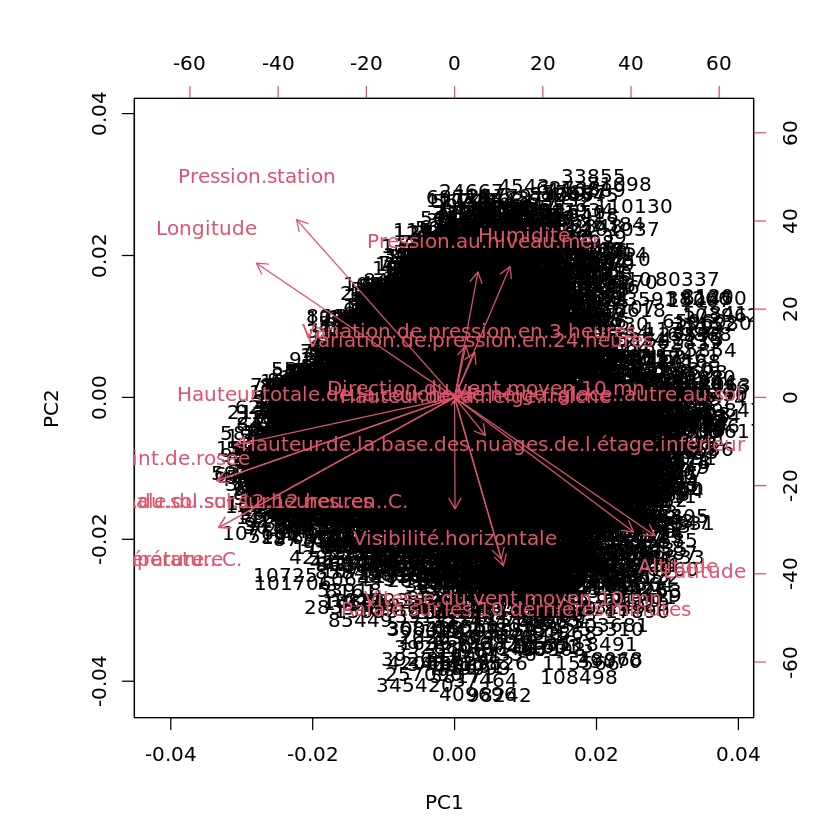

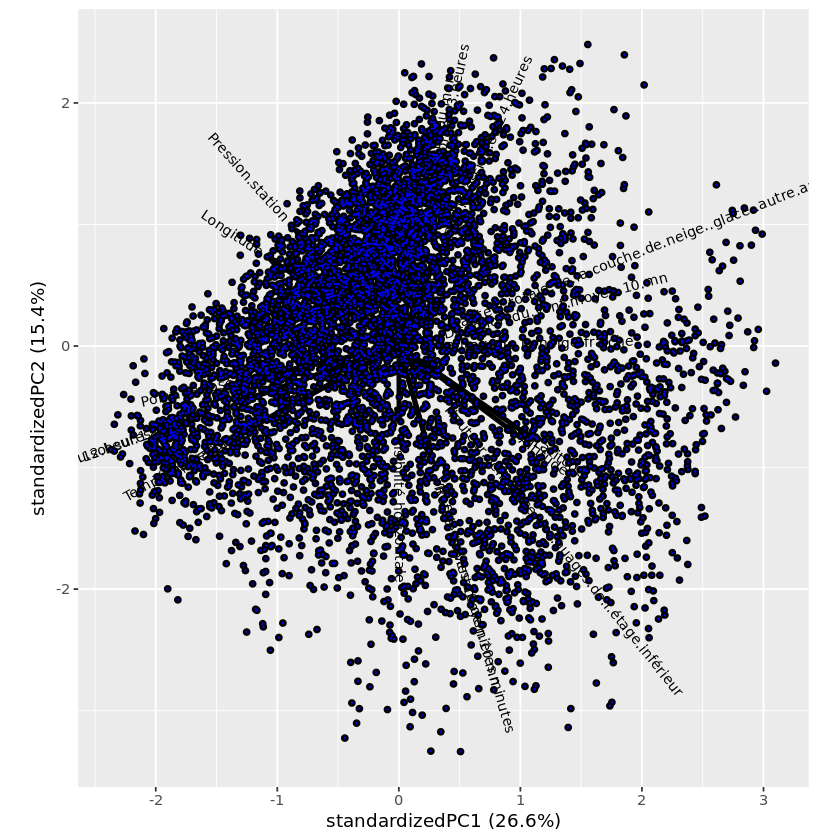

In [139]:

# Install if needed

library(ggbiplot)

# Perform PCA
pca <- prcomp(data_for_acp, scale. = TRUE)

biplot(pca)
# Create a biplot with points for rows
ggbiplot(pca, labels = NULL, var.axes = TRUE, cex = 0) +
  geom_point(size = 0, color = "blue")  # Add points for rows


